In [1]:
import matplotlib.pyplot as plot

In [2]:
import cv2

In [3]:
import pandas
import math

In [4]:
import scipy

In [5]:
from copy import deepcopy

In [6]:
segmented_word_path = r"C:\Users\charm\PycharmProjects\cheque\word_segmentation_results\data_2.png"

read the image

In [7]:
image_of_word = cv2.imread(segmented_word_path)

then display the image

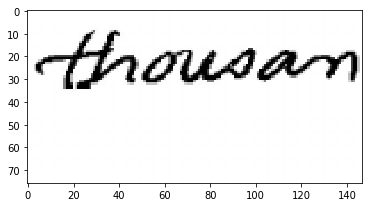

In [8]:
plot.imshow(image_of_word)
plot.show()

In [9]:
image_of_word.shape

(76, 147, 3)

In [10]:
benchmark_black = [10, 10, 10]

In [11]:
def calculate_stroke_width(image): 
    #each row of pixels 
    all_stroke_widths = []
    all_stroke_locations = []
    for row_index, row in enumerate(image):
        running_stroke = False
        current_width = 0
        pixel_indices = []
        for column_index, column in enumerate(row): 
            if (column[0] <= benchmark_black[0] and column[1] <= benchmark_black[1] and column[2] <= benchmark_black[2]):
                running_stroke = True
                current_width = current_width + 1
                pixel_indices.append((row_index, column_index))
            else: 
                if(current_width > 0):
                    all_stroke_widths.append(current_width)
                    all_stroke_locations.append(deepcopy(pixel_indices))
                    current_width = 0
                    pixel_indices = []
                running_stroke = False
        if(current_width > 0):
            all_stroke_widths.append(current_width)
            all_stroke_locations.append(deepcopy(pixel_indices))
            current_width = 0
    return all_stroke_widths, all_stroke_locations
                    
all_stroke_widths, all_stroke_width_locations = calculate_stroke_width(image_of_word)

In [12]:
 all_stroke_widths = pandas.DataFrame(all_stroke_widths)

In [13]:
mean_stroke = all_stroke_widths.mean()[0]

In [14]:
#now calculate the length-wise stroke
def calculate_stroke_height(image): 
    all_stroke_height = []
    all_stroke_locations = []
    for column_index in range(0, (image.shape[1])): #loop through each column
        running_stroke = False
        current_height = 0
        pixel_indices = []
        column = image[:,column_index]
        for row_index in enumerate(column): 
            if (column[0] <= benchmark_black[0] and column[1] <= benchmark_black[1] and column[2] <= benchmark_black[2]):
                running_stroke = True
                current_height = current_height + 1
                pixel_indices.append((row_index, column_index))
            else: 
                if(current_height > 0):
                    all_stroke_height.append(current_height)
                    all_stroke_locations.append(deepcopy(pixel_indices))
                    current_height = 0
                    pixel_indices = []
                running_stroke = False
        if(current_height > 0):
            all_stroke_height.append(current_width)
            all_stroke_locations.append(deepcopy(pixel_indices))
            current_height = 0
    return all_stroke_height, all_stroke_locations
                    
all_stroke_height, all_stroke_height_locations = calculate_stroke_width(image_of_word)

In [15]:
#get row with the max number of strokes as the row that represent roughly the one that has all the characters
def calculate_row_with_max_separate_stokes(image): 
    #each row of pixels 
    max_strokes= -1
    max_strokes_index = -1
    for row_index, row in enumerate(image):
        running_stroke = False
        number_of_indv_strokes = 0
        for column_index, column in enumerate(row): 
            if (column[0] <= benchmark_black[0] and column[1] <= benchmark_black[1] and column[2] <= benchmark_black[2]):
                running_stroke = True
            else: 
                if running_stroke:
                    number_of_indv_strokes = number_of_indv_strokes + 1
                running_stroke = False
        if(number_of_indv_strokes > max_strokes):
            max_strokes = number_of_indv_strokes
            max_stroke_index = row_index
    return max_stroke_index
max_stroke_index = calculate_row_with_max_separate_stokes(image_of_word)

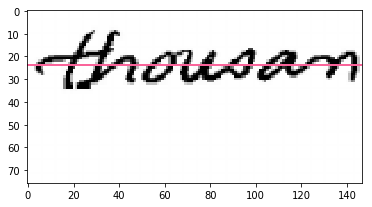

In [16]:
#visualise the row with the most strokes
image_for_visuals = deepcopy(image_of_word)
image_for_visuals[max_stroke_index] = [[250, 100, 154] for pixel in image_for_visuals[max_stroke_index]]
plot.imshow(image_for_visuals)
plot.show()

In [17]:
#we only want those strokes less than within 1 pixel of the mean as candidates to search from 
def prune_for_candidate_search(image) :
    row_with_most_strokes = image[max_stroke_index]
    row_with_most_strokes_widths_and_locations = [] 
    pruned_strokes = []
    pixel_indices = []
    current_stroke_width = 0
    for column_index, column in enumerate(row_with_most_strokes): 
            if (column[0] <= benchmark_black[0] and column[1] <= benchmark_black[1] and column[2] <= benchmark_black[2]):
                running_stroke = True
                current_stroke_width = current_stroke_width + 1
                pixel_indices.append((max_stroke_index, column_index))
            else: 
                if(current_stroke_width > 0):
                    row_with_most_strokes_widths_and_locations.append((current_stroke_width, deepcopy(pixel_indices)))
                    current_stroke_width = 0
                    pixel_indices = []
                running_stroke = False
    if(current_stroke_width > 0):
        row_with_most_strokes_widths_and_locations.append((current_stroke_width, deepcopy(pixel_indices)))
        current_width = 0
    for candidate_stroke in row_with_most_strokes_widths_and_locations:
        if candidate_stroke[0] >= mean_stroke - 1 and candidate_stroke[0] <= mean_stroke + 1:
            pruned_strokes.extend(candidate_stroke[1])
    
    return pruned_strokes
strokes_pruned = prune_for_candidate_search(image_of_word)

In [18]:
image_for_visuals.shape

(76, 147, 3)

In [19]:
#now we need to get the lowest pixels for each of the strokes - we use a depth first search downwards 
def find_lowest_pixels(unvisited_pixels, image) : 
    visited_pixels = [] 
    unvisited_pixels.reverse()
    lowest_pixels = []
    while len(unvisited_pixels) > 0: 
        current_pixel = unvisited_pixels.pop()
        visited_pixels.append(current_pixel)
                
        search_paths = [(current_pixel[0] + 1, current_pixel[1] - 1), (current_pixel[0] + 1, current_pixel[1]), (current_pixel[0] + 1, current_pixel[1] + 1),
                        (current_pixel[0] + 1, current_pixel[1] - 2), (current_pixel[0] + 1, current_pixel[1] + 2),
                       (current_pixel[0] + 1, current_pixel[1] - 3), (current_pixel[0] + 1, current_pixel[1] + 3),
                       (current_pixel[0] + 1, current_pixel[1] - 4), (current_pixel[0] + 1, current_pixel[1] + 4),
                       (current_pixel[0] + 1, current_pixel[1] - 5), (current_pixel[0] + 1, current_pixel[1] + 5),]
         
        added_children = False
        has_children = False
        
        for search_path in search_paths:
            if (search_path not in visited_pixels and search_path[0] < image.shape[0] and search_path[1] < image.shape[1] and 
                image[search_path][0] <= benchmark_black[0] and image[search_path][1] <= benchmark_black[1] and
                image[search_path][2] <= benchmark_black[2]):
                    unvisited_pixels.append(search_path)
                    added_children = True
            elif (search_path in visited_pixels and search_path[0] < image.shape[0] and search_path[1] < image.shape[1] and 
                image[search_path][0] <= benchmark_black[0] and image[search_path][1] <= benchmark_black[1] and
                image[search_path][2] <= benchmark_black[2]):
                    has_children = True
        
        if not added_children and not has_children:
            lowest_pixels.append(current_pixel)
    
        
    return lowest_pixels

lowest_points = find_lowest_pixels(deepcopy(strokes_pruned), image_of_word)

In [20]:
#now we need to get the highest pixels for each of the strokes - we use a depth first search highest 
def find_highest_pixels(unvisited_pixels, image) : 
    visited_pixels = [] 
    unvisited_pixels.reverse()
    highest_pixels = []
    while len(unvisited_pixels) > 0: 
        current_pixel = unvisited_pixels.pop()
        visited_pixels.append(current_pixel)

        added_children = False
        
        has_children = False
        
        search_paths = [(current_pixel[0] - 1, current_pixel[1] - 1), (current_pixel[0] - 1, current_pixel[1]),
                       (current_pixel[0] - 1, current_pixel[1] + 1),
                        (current_pixel[0] - 1, current_pixel[1] - 2), (current_pixel[0] - 1, current_pixel[1] + 2),
                         (current_pixel[0] - 1, current_pixel[1] - 3), (current_pixel[0] - 1, current_pixel[1] + 3),
                         (current_pixel[0] - 1, current_pixel[1] - 4), (current_pixel[0] - 1, current_pixel[1] + 4),
                         (current_pixel[0] - 1, current_pixel[1] - 5), (current_pixel[0] - 1, current_pixel[1] + 5)]
        
        for search_path in search_paths:
            if (search_path not in visited_pixels and search_path[0] < image.shape[0] and search_path[1] < image.shape[1] and 
                image[search_path][0] <= benchmark_black[0] and image[search_path][1] <= benchmark_black[1] and
                image[search_path][2] <= benchmark_black[2]):
                    unvisited_pixels.append(search_path)
                    added_children = True
            elif (search_path in visited_pixels and search_path[0] < image.shape[0] and search_path[1] < image.shape[1] and 
                image[search_path][0] <= benchmark_black[0] and image[search_path][1] <= benchmark_black[1] and
                image[search_path][2] <= benchmark_black[2]):
                    has_children = True
            
        if not added_children and not has_children :
            highest_pixels.append(current_pixel)
        
    return highest_pixels

highest_points = find_highest_pixels(deepcopy(strokes_pruned), image_of_word)

In [22]:
def clean_up_points(points):
    points_copy = deepcopy(points)
    
    for point in points_copy: 
        eastern_point = (point[0], point[1]+1)
        if eastern_point in points:
            points.remove(point)
    
    return points

clean_up_points(lowest_points)
clean_up_points(highest_points)

[(11, 27),
 (21, 14),
 (21, 12),
 (21, 10),
 (10, 39),
 (10, 37),
 (21, 46),
 (21, 44),
 (21, 42),
 (19, 62),
 (19, 81),
 (18, 98),
 (18, 96),
 (18, 113),
 (21, 109),
 (19, 142),
 (19, 140),
 (21, 132)]

In [ ]:
lowest_points

In [ ]:
#draw this so we can visualise
def visualise_points( all_points, image, colour=[235, 38, 70]):
    for point in all_points: 
        image[point] = colour
    plot.imshow(image)
    plot.show()

    
all_points = []
all_points.extend(lowest_points)
all_points.extend(highest_points)
visualise_points(all_points, image_for_visuals)

In [ ]:
lowest_points

In [ ]:

def follow_east_and_segment_higher(highest_points, image):
    visited_pixels = [] 
    unvisited_pixels = highest_points
    unvisited_pixels.reverse()
    lines = []
    while len(unvisited_pixels) > 0: 
        current_pixel = unvisited_pixels.pop()
        visited_pixels.append(current_pixel)

        found_edge = True
        print("Checking", current_pixel)
        
        if found_edge:
            temp_pixel = (0, current_pixel[1])
            while(temp_pixel[0] != max_stroke_index) :
                #move right if black found 
                
                searched_for_black = False
                while (image[temp_pixel][0] <= benchmark_black[0] and image[temp_pixel][1] <= benchmark_black[1] and
                        image[temp_pixel][2] <= benchmark_black[2]):
                        temp_pixel = (temp_pixel[0], temp_pixel[1] + 1)
                        searched_for_black = True
                lines.append(temp_pixel)
                
                if temp_pixel[1] > current_pixel[1] and not searched_for_black:
                    temp_pixel = (temp_pixel[0] + 1, temp_pixel[1]  - 1)
                else:
                    temp_pixel = (temp_pixel[0] + 1, temp_pixel[1])
                #go straight down if within mid line
                
           
        
    return lines
lines = follow_east_and_segment_higher(highest_points, image_of_word)
visualise_points(lines, image_for_visuals,[125, 78, 230])

In [ ]:
lines

In [ ]:
lines

In [ ]:
def follow_east_and_segment_lower(points, image):
    visited_pixels = [] 
    unvisited_pixels = points
    unvisited_pixels.reverse()

    lines = []
    while len(unvisited_pixels) > 0: 
        current_pixel = unvisited_pixels.pop()
        visited_pixels.append(current_pixel)

        found_edge = True
                
        if found_edge:
            temp_pixel = (image.shape[0] - 1, current_pixel[1])
            while(temp_pixel[0] != max_stroke_index):
                #move right if black found 
                searched_for_black = False
                while (image[temp_pixel][0] <= benchmark_black[0] and image[temp_pixel][1] <= benchmark_black[1] and
                        image[temp_pixel][2] <= benchmark_black[2]):
                        temp_pixel = (temp_pixel[0], temp_pixel[1] + 1)
                        searched_for_black = True
                lines.append(temp_pixel)
                if temp_pixel[1] > current_pixel[1] and not searched_for_black:
                    temp_pixel = (temp_pixel[0] - 1, temp_pixel[1] - 1)
                else:
                    temp_pixel = (temp_pixel[0] - 1, temp_pixel[1])
           
        
    return lines
lines = follow_east_and_segment_lower(lowest_points, image_of_word)
visualise_points(lines, image_for_visuals, [125, 78, 230])